In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from functools import partial

!pip install pkbar wandb
!rm -rf potatorch 
!git clone https://github.com/crybot/potatorch potatorch-clone
!cp -r potatorch-clone/src/potatorch ./potatorch
!rm -rf potatorch-clone

import potatorch
from potatorch.training import TrainingLoop, make_optimizer
from potatorch.callbacks import ProgressbarCallback
from potatorch.optimization.tuning import HyperOptimizer
from torch.utils.data import TensorDataset


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


Cloning into 'potatorch-clone'...


remote: Enumerating objects: 636, done.
remote: Counting objects: 100% (79/79), done.


remote: Compressing objects: 100% (41/41), done.


remote: Total 636 (delta 47), reused 47 (delta 35), pack-reused 557


Receiving objects: 100% (636/636), 2.28 MiB | 5.98 MiB/s, done.
Resolving deltas: 100% (368/368), done.


# Dataset loading



In [3]:
df = pd.read_csv('./NARMA10.csv', header=None)
print(df.head())

       0        1        2        3        4         5        6         7      
0  0.083964  0.48934  0.35635  0.25024  0.23554  0.029809  0.34099  0.021216  \
1  0.000000  0.00000  0.00000  0.00000  0.00000  0.000000  0.00000  0.000000   

       8        9     ...     9990     9991     9992     9993     9994   
0  0.035723  0.26082  ...  0.08209  0.19951  0.26618  0.43761  0.32952  \
1  0.000000  0.00000  ...  0.26495  0.21299  0.26849  0.19633  0.32609   

      9995      9996     9997     9998      9999  
0  0.39381  0.063013  0.26249  0.44974  0.054542  
1  0.31816  0.448240  0.26351  0.20217  0.365350  

[2 rows x 10000 columns]


## Architecture

In [5]:
class EchoStateNetwork():
    """Echo state network implementation."""
    
    def __init__(self,
                 neurons,
                 input_dim,
                 stateful = True,
                 omega_x = 1,
                 omega_b = 1,
                 rho = 0.9,
                 *args, **kwargs):
        """Echo state network constructor.
        
        Arguments:
        neurons   -- number of units within the reservoir
        input_dim -- number of input features
        
        Keyword arguments:
        stateful -- whether to use the last hidden state as the current one (default True)
        omega_x  -- scaling parameter for the input weight matrix (default 1.0)
        omega_b  -- scaling parameter for the bias vector (default 1.0)
        rho      -- desired spectral radius of the recurrent weight matrix (default 0.9)
        """
        self.neurons = neurons
        self.input_dim = input_dim
        self.Wh = np.random.random((neurons, neurons))*2 - 1
        self.Wx = np.random.random((neurons, input_dim))*2*omega_x - omega_x
        self.h0 = np.zeros((neurons, 1))
        self.omega_x = omega_x
        self.omega_b = omega_b
        self.rho = rho
        
        self.b = np.random.random(neurons)*2*omega_b - omega_b
        self.Wo = np.zeros((1, neurons + 1))
        
        self.stateful = stateful
        self._scale()
    
    def _scale(self):
        """Scale the recurrent weight matrix by `self.rho`."""
        eigs, _ = np.linalg.eig(self.Wh)
        rho_wh = np.max(np.abs(eigs))
        self.Wh = self.rho * self.Wh / rho_wh
    
    def train(self, input, target, ridge = False, washout = 0):
        """Learn readout layer by linear regression."""
        _, _, states = self.forward(input, collect_states=True)
        states = np.hstack((states, np.ones((states.shape[0], 1))))
        N = int(washout * len(states))
        states = states[N:, :]
        target = target[N:]
        if ridge:
            states_inv = np.linalg.pinv(np.dot(states.T, states) + self.k * np.eye(states.shape[1]))
            self.Wo = np.dot(np.dot(states_inv, states.T), target)
        else:
            states_inv = np.linalg.pinv(states)
            self.Wo = states_inv @ target
    
    def forward(self, x, collect_states=False):
        """Perform a forward pass over the input sequence.
        
        Arguments:
        x -- input sequence
        
        Keyword arguments:
        collect_state -- whether the method should return the hidden states collected into a matrix (default False)
        
        Returns:
        The last output and hidden states. Also returns every computed hidden states if collect_states=True.
        """
        ht = np.zeros(self.neurons)
        if collect_states:
            hs = []
            
        for xt in x:
            xt = np.atleast_1d(xt)
            ht = np.tanh(self.Wh @ ht + self.Wx @ xt + self.b)
            if collect_states:
                hs.append(ht)
            
        if self.stateful:
            self.h0 = ht
            
        out = self.Wo @ np.append(ht, [1])
        if collect_states:
            return out, ht, np.array(hs)
        
        return out, ht
    
    def predict(self, x):
        """Compute the output of the network given a sequence, after collecting the hidden states."""
        _, _, states = self.forward(x, collect_states=True)
        states = np.hstack((states, np.ones((states.shape[0], 1))))
        return states @ self.Wo
    
    def dump(self, dump_file):
        """Dump weights matrices to disk as a binary numpy file."""
        np.savez(dump_file, wh=self.Wh, wx=self.Wx, wo=self.Wo, b=self.b)
        
    def load(self, dump_file):
        """Load a dump file into memory, initializing the model."""
        weights = np.load(dump_file)
        self.Wh = weights['wh']
        self.Wx = weights['wx']
        self.Wo = weights['wo']
        self.b = weights['b']


In [17]:
def prediction_plot(model, x, y, length=None, washout = 0.1, title = 'prediction plot', save_file=None):
    """Plot ground truth and prediction sequences."""
    washout = int(len(y) * washout)
    if not length:
        length = len(y)
    t = range(length - washout)
    
    prediction = model.predict(x)[washout:]
    y = y[washout:]
    plt.plot(t, prediction[:len(t)], label='prediction')
    plt.plot(range(len(y)), y, label='ground truth')
    plt.title(title)
    plt.legend()
    
    if save_file:
        plt.savefig(save_file)
        
    plt.show()

In [7]:
def evaluate(model, x, y):
    prediction = model.predict(x)
    return np.mean((prediction - y)**2) 
    
def train(config, train_x, train_y, val_x, val_y, iterations=10, plot=False, eval_metric='val_loss', washout=0.1): 
    loss = 0.0
    val_loss = 0.0
    
    # Perform a number of re-initialization and average the resulting errors
    for _ in range(iterations):
        esn = EchoStateNetwork(**config, input_dim=1, stateful=True)
        esn.train(train_x, train_y, washout = washout)
        
        loss += evaluate(esn, train_x, train_y)
        val_loss += evaluate(esn, val_x, val_y)
        
        if plot:
            prediction_plot(esn, val_x, val_y, washout = washout)
            
    loss /= iterations
    val_loss /= iterations
    return esn, {'loss': loss, eval_metric: val_loss}


In [8]:
sweep_config = {
    'method': 'bayes',
    'iterations': 100,
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'neurons': {
            'distribution': 'uniform',
            'min': 10,
            'max': 200
        },
        'rho': {
            'distribution': 'uniform',
            'min': 0.1,
            'max': 1.0
        },
        'omega_x': {
            'distribution': 'uniform',
            'min': 0.01,
            'max': 1.0
        },
        'omega_b': {
            'distribution': 'uniform',
            'min': 0.01,
            'max': 1.0
        }
    },
    'fixed': {
        'verbose': 0
    }
    
}

In [9]:
def split(ds, train_size, val_size):
    N = train_size + val_size
    train_x = ds[0, :N]
    train_y = ds[1, :N]

    val_x = train_x[-val_size:]
    val_y = train_y[-val_size:]

    train_x = train_x[:train_size]
    train_y = train_y[:train_size]

    test_x = ds[0, N:]
    test_y = ds[1, N:]
    return train_x, train_y, val_x, val_y, test_x, test_y

## **Hyperparameters optimization**



In [10]:
train_x, train_y, val_x, val_y, test_x, test_y = split(df.values, 4000, 1000)

score_function = lambda config: train(config, train_x, train_y, val_x, val_y, plot = False)[1]

optimizer = HyperOptimizer(sweep_config)
best_config, error = optimizer.optimize(score_function, return_error=True)
print('Best configuration found: {}\n with error: {}'.format(best_config, error))

Evaluating configuration: {'verbose': 0, 'neurons': 31, 'rho': 0.8424207546289477, 'omega_x': 0.8675877661262287, 'omega_b': 0.654393143919807}


Evaluating configuration: {'verbose': 0, 'neurons': 156, 'rho': 0.5747650210367911, 'omega_x': 0.4778306319661654, 'omega_b': 0.2936660928173871}


Evaluating configuration: {'verbose': 0, 'neurons': 128, 'rho': 0.853405090910539, 'omega_x': 0.5901282996983461, 'omega_b': 0.08151522610231923}


Evaluating configuration: {'verbose': 0, 'neurons': 79, 'rho': 0.7236882372761505, 'omega_x': 0.4821743020179755, 'omega_b': 0.5661356144796715}


Evaluating configuration: {'verbose': 0, 'neurons': 67, 'rho': 0.9806043372757088, 'omega_x': 0.5978590054129058, 'omega_b': 0.21669536523679422}


Evaluating configuration: {'verbose': 0, 'neurons': 98, 'rho': 0.1246875759913344, 'omega_x': 0.9822294590503694, 'omega_b': 0.10228236199359611}


Evaluating configuration: {'verbose': 0, 'neurons': 20, 'rho': 0.8337483234459849, 'omega_x': 0.289243343619783, 'omega_b': 0.8221863646539781}


Evaluating configuration: {'verbose': 0, 'neurons': 60, 'rho': 0.654191711676545, 'omega_x': 0.4128810832968709, 'omega_b': 0.6848186508848104}


Evaluating configuration: {'verbose': 0, 'neurons': 44, 'rho': 0.8183776421804321, 'omega_x': 0.33541126840329594, 'omega_b': 0.8237222703285486}


Evaluating configuration: {'verbose': 0, 'neurons': 123, 'rho': 0.44458148760731775, 'omega_x': 0.5753656107165454, 'omega_b': 0.2812542339008291}


Evaluating configuration: {'verbose': 0, 'neurons': 183, 'rho': 0.2941476840519475, 'omega_x': 0.5002101642909511, 'omega_b': 0.4630221971018298}


Evaluating configuration: {'verbose': 0, 'neurons': 162, 'rho': 0.807055729370943, 'omega_x': 0.5802481967616621, 'omega_b': 0.921893559336695}


Evaluating configuration: {'verbose': 0, 'neurons': 193, 'rho': 0.40740633715778185, 'omega_x': 0.3094829638837668, 'omega_b': 0.8080667364930837}


Evaluating configuration: {'verbose': 0, 'neurons': 83, 'rho': 0.8866866671008794, 'omega_x': 0.12361894000501397, 'omega_b': 0.9119917329709387}


Evaluating configuration: {'verbose': 0, 'neurons': 188, 'rho': 0.9308313041714738, 'omega_x': 0.0359758949824456, 'omega_b': 0.7461873252542368}


Evaluating configuration: {'verbose': 0, 'neurons': 107, 'rho': 0.36925273703330497, 'omega_x': 0.1481523589936989, 'omega_b': 0.9499451674097871}


Evaluating configuration: {'verbose': 0, 'neurons': 197, 'rho': 0.5901206766755687, 'omega_x': 0.9360508527780831, 'omega_b': 0.15543418359154507}


Evaluating configuration: {'verbose': 0, 'neurons': 55, 'rho': 0.7759595027508466, 'omega_x': 0.5564579692496278, 'omega_b': 0.27084842566522016}


Evaluating configuration: {'verbose': 0, 'neurons': 14, 'rho': 0.11628564353931142, 'omega_x': 0.739964914047855, 'omega_b': 0.027475830691313582}


Evaluating configuration: {'verbose': 0, 'neurons': 159, 'rho': 0.4532225539817558, 'omega_x': 0.07646222934675385, 'omega_b': 0.6337720620219489}


Evaluating configuration: {'verbose': 0, 'neurons': 141, 'rho': 0.12568593053230773, 'omega_x': 0.5547537611021595, 'omega_b': 0.6530657342137465}


Evaluating configuration: {'verbose': 0, 'neurons': 28, 'rho': 0.8693312247984133, 'omega_x': 0.572993968235776, 'omega_b': 0.7755849563183694}


Evaluating configuration: {'verbose': 0, 'neurons': 94, 'rho': 0.7320004499950583, 'omega_x': 0.050107040221894515, 'omega_b': 0.2737845422885331}


Evaluating configuration: {'verbose': 0, 'neurons': 23, 'rho': 0.5014263592836249, 'omega_x': 0.10258635294452471, 'omega_b': 0.874230666696865}


Evaluating configuration: {'verbose': 0, 'neurons': 171, 'rho': 0.3094605939103379, 'omega_x': 0.8121189343253671, 'omega_b': 0.4375531222951878}


Evaluating configuration: {'verbose': 0, 'neurons': 146, 'rho': 0.3776753216357488, 'omega_x': 0.7553209554395212, 'omega_b': 0.018844196916384195}


Evaluating configuration: {'verbose': 0, 'neurons': 103, 'rho': 0.812240393658003, 'omega_x': 0.0772130000681691, 'omega_b': 0.667108683444529}


Evaluating configuration: {'verbose': 0, 'neurons': 48, 'rho': 0.9264819010111227, 'omega_x': 0.09345991322566465, 'omega_b': 0.965718110212316}


Evaluating configuration: {'verbose': 0, 'neurons': 36, 'rho': 0.7948815723578879, 'omega_x': 0.18246958505413638, 'omega_b': 0.2647004371329257}


Evaluating configuration: {'verbose': 0, 'neurons': 72, 'rho': 0.8675391508232309, 'omega_x': 0.5744320837204863, 'omega_b': 0.5591495710761378}


Evaluating configuration: {'verbose': 0, 'neurons': 165, 'rho': 0.4195565840388671, 'omega_x': 0.5075622828359206, 'omega_b': 0.8746663254685074}


Evaluating configuration: {'verbose': 0, 'neurons': 120, 'rho': 0.684148735537338, 'omega_x': 0.910340319943936, 'omega_b': 0.058998723703572654}


Evaluating configuration: {'verbose': 0, 'neurons': 10, 'rho': 0.5435097659015472, 'omega_x': 0.1449080432032221, 'omega_b': 0.6380540620723549}


Evaluating configuration: {'verbose': 0, 'neurons': 112, 'rho': 0.8667662254392895, 'omega_x': 0.46541395943322833, 'omega_b': 0.458172723877297}


Evaluating configuration: {'verbose': 0, 'neurons': 175, 'rho': 0.8198039875066331, 'omega_x': 0.7394818605983292, 'omega_b': 0.4622121531538083}


Evaluating configuration: {'verbose': 0, 'neurons': 131, 'rho': 0.31798492478591955, 'omega_x': 0.7952433699582435, 'omega_b': 0.07511727692751842}


Evaluating configuration: {'verbose': 0, 'neurons': 152, 'rho': 0.6688551085002001, 'omega_x': 0.5971307081369702, 'omega_b': 0.13977975336122053}


Evaluating configuration: {'verbose': 0, 'neurons': 75, 'rho': 0.45648246251623203, 'omega_x': 0.1690645815122102, 'omega_b': 0.3378803683470567}


Evaluating configuration: {'verbose': 0, 'neurons': 40, 'rho': 0.8847475105406257, 'omega_x': 0.6661971626881894, 'omega_b': 0.34268936156702}


Evaluating configuration: {'verbose': 0, 'neurons': 137, 'rho': 0.9905357679970686, 'omega_x': 0.5464865291448768, 'omega_b': 0.3410485240026345}


Evaluating configuration: {'verbose': 0, 'neurons': 134, 'rho': 0.48030268952761734, 'omega_x': 0.5555785323340512, 'omega_b': 0.4637399079593153}


Evaluating configuration: {'verbose': 0, 'neurons': 86, 'rho': 0.7092884445768626, 'omega_x': 0.8680334677974879, 'omega_b': 0.25038332581587314}


Evaluating configuration: {'verbose': 0, 'neurons': 200, 'rho': 0.8487254491097761, 'omega_x': 0.5543390297628602, 'omega_b': 0.06622597182360979}


Evaluating configuration: {'verbose': 0, 'neurons': 51, 'rho': 0.534713737264515, 'omega_x': 0.5430287801746165, 'omega_b': 0.5505358418095632}


Evaluating configuration: {'verbose': 0, 'neurons': 115, 'rho': 0.22891674625936326, 'omega_x': 0.023767273903671397, 'omega_b': 0.6651169379281247}


Evaluating configuration: {'verbose': 0, 'neurons': 149, 'rho': 0.33134189893297156, 'omega_x': 0.8771779115640549, 'omega_b': 0.4414476705413692}


Evaluating configuration: {'verbose': 0, 'neurons': 64, 'rho': 0.16693690103113337, 'omega_x': 0.3620143087526802, 'omega_b': 0.4761100948743035}


Evaluating configuration: {'verbose': 0, 'neurons': 89, 'rho': 0.2964825707418724, 'omega_x': 0.07525942337036917, 'omega_b': 0.6138622449218856}


Evaluating configuration: {'verbose': 0, 'neurons': 168, 'rho': 0.9004155839897054, 'omega_x': 0.31645931383734893, 'omega_b': 0.8140441710785634}


Evaluating configuration: {'verbose': 0, 'neurons': 17, 'rho': 0.1596430960470151, 'omega_x': 0.9449979549090601, 'omega_b': 0.13547417586472535}


Evaluating configuration: {'verbose': 0, 'neurons': 179, 'rho': 0.2691793409684493, 'omega_x': 0.5157856185275987, 'omega_b': 0.09166930839397121}


Evaluating configuration: {'verbose': 0, 'neurons': 26, 'rho': 0.21504975106834523, 'omega_x': 0.2688147298841667, 'omega_b': 0.6360974120417333}


Evaluating configuration: {'verbose': 0, 'neurons': 69, 'rho': 0.430247137776693, 'omega_x': 0.993737839425115, 'omega_b': 0.7622712585442489}


Evaluating configuration: {'verbose': 0, 'neurons': 126, 'rho': 0.16021169642401722, 'omega_x': 0.45148622050401244, 'omega_b': 0.5572262194888595}


Evaluating configuration: {'verbose': 0, 'neurons': 38, 'rho': 0.24563787121736583, 'omega_x': 0.7792222565444801, 'omega_b': 0.26556344860694475}


Evaluating configuration: {'verbose': 0, 'neurons': 34, 'rho': 0.14204861285075074, 'omega_x': 0.0745729930604658, 'omega_b': 0.6271854970571987}


Evaluating configuration: {'verbose': 0, 'neurons': 144, 'rho': 0.5822675340892339, 'omega_x': 0.16044148738363612, 'omega_b': 0.9338339447121781}


Evaluating configuration: {'verbose': 0, 'neurons': 110, 'rho': 0.11388863536835869, 'omega_x': 0.9172462776539884, 'omega_b': 0.2817817001397403}


Evaluating configuration: {'verbose': 0, 'neurons': 12, 'rho': 0.34796524577238014, 'omega_x': 0.4614816552109317, 'omega_b': 0.06350952788795129}


Evaluating configuration: {'verbose': 0, 'neurons': 57, 'rho': 0.9997470271890252, 'omega_x': 0.3778539890432793, 'omega_b': 0.8981668578652736}


Evaluating configuration: {'verbose': 0, 'neurons': 100, 'rho': 0.5981140284839421, 'omega_x': 0.31921183298311084, 'omega_b': 0.9615624606648209}


Evaluating configuration: {'verbose': 0, 'neurons': 16, 'rho': 0.9455392507890867, 'omega_x': 0.190053005479903, 'omega_b': 0.9138294183867031}


Evaluating configuration: {'verbose': 0, 'neurons': 118, 'rho': 0.5874437631538812, 'omega_x': 0.9417773290771774, 'omega_b': 0.12279802784720172}


Evaluating configuration: {'verbose': 0, 'neurons': 42, 'rho': 0.6733350808004177, 'omega_x': 0.28320084790782735, 'omega_b': 0.8156302601569436}


Evaluating configuration: {'verbose': 0, 'neurons': 154, 'rho': 0.9884723877386467, 'omega_x': 0.2098779859501751, 'omega_b': 0.7397443357684708}


Evaluating configuration: {'verbose': 0, 'neurons': 53, 'rho': 0.1386302100632482, 'omega_x': 0.054522233587095834, 'omega_b': 0.17257691313285758}


Evaluating configuration: {'verbose': 0, 'neurons': 56, 'rho': 0.6986223925012877, 'omega_x': 0.17831200943980297, 'omega_b': 0.014152827869471389}


Evaluating configuration: {'verbose': 0, 'neurons': 46, 'rho': 0.8923567676898998, 'omega_x': 0.408202123759488, 'omega_b': 0.6652033863932115}


Evaluating configuration: {'verbose': 0, 'neurons': 129, 'rho': 0.8592938234342131, 'omega_x': 0.02888634641938894, 'omega_b': 0.8442500566846954}


Evaluating configuration: {'verbose': 0, 'neurons': 177, 'rho': 0.9275295826780472, 'omega_x': 0.5204310095547571, 'omega_b': 0.9760535998043707}


Evaluating configuration: {'verbose': 0, 'neurons': 18, 'rho': 0.8930288312017387, 'omega_x': 0.2847368679551855, 'omega_b': 0.7965467494304277}


Evaluating configuration: {'verbose': 0, 'neurons': 96, 'rho': 0.32102033956074455, 'omega_x': 0.6670921940063761, 'omega_b': 0.05069695217141627}


Evaluating configuration: {'verbose': 0, 'neurons': 128, 'rho': 0.45574421047669766, 'omega_x': 0.8462315261687455, 'omega_b': 0.13717478864818058}


Evaluating configuration: {'verbose': 0, 'neurons': 92, 'rho': 0.6959445285260686, 'omega_x': 0.9749157700507484, 'omega_b': 0.23664364074650399}


Evaluating configuration: {'verbose': 0, 'neurons': 138, 'rho': 0.11389097986896994, 'omega_x': 0.4706405707935497, 'omega_b': 0.9401804838039595}


Evaluating configuration: {'verbose': 0, 'neurons': 81, 'rho': 0.26962504768042966, 'omega_x': 0.05524123117655676, 'omega_b': 0.16120167693566628}


Evaluating configuration: {'verbose': 0, 'neurons': 136, 'rho': 0.6145994695175064, 'omega_x': 0.29076315752168547, 'omega_b': 0.3538714734763979}


Evaluating configuration: {'verbose': 0, 'neurons': 77, 'rho': 0.7277783144746798, 'omega_x': 0.23512322460036494, 'omega_b': 0.7261686130339865}


Evaluating configuration: {'verbose': 0, 'neurons': 199, 'rho': 0.1963351146093996, 'omega_x': 0.08096691072790506, 'omega_b': 0.8030339290314208}


Evaluating configuration: {'verbose': 0, 'neurons': 196, 'rho': 0.7598016546397997, 'omega_x': 0.2176252751069101, 'omega_b': 0.7579891560876861}


Evaluating configuration: {'verbose': 0, 'neurons': 137, 'rho': 0.8999099910341589, 'omega_x': 0.4105020624505769, 'omega_b': 0.07201693436034656}


Evaluating configuration: {'verbose': 0, 'neurons': 197, 'rho': 0.9616225467095862, 'omega_x': 0.695739428089341, 'omega_b': 0.0161067043862888}


Evaluating configuration: {'verbose': 0, 'neurons': 190, 'rho': 0.11197645331242662, 'omega_x': 0.9416680765289668, 'omega_b': 0.6296917553464645}


Evaluating configuration: {'verbose': 0, 'neurons': 173, 'rho': 0.9639547065470926, 'omega_x': 0.8149773246686155, 'omega_b': 0.7042777064540735}


Evaluating configuration: {'verbose': 0, 'neurons': 128, 'rho': 0.8476629964332484, 'omega_x': 0.959902100851812, 'omega_b': 0.2867528703512795}


Evaluating configuration: {'verbose': 0, 'neurons': 121, 'rho': 0.5141914504167905, 'omega_x': 0.10746120277648392, 'omega_b': 0.27727776008128885}


Evaluating configuration: {'verbose': 0, 'neurons': 119, 'rho': 0.7420391273365309, 'omega_x': 0.5196357755511198, 'omega_b': 0.27001208861270587}


Evaluating configuration: {'verbose': 0, 'neurons': 186, 'rho': 0.6684169671816078, 'omega_x': 0.92403790021071, 'omega_b': 0.1642948688954555}


Evaluating configuration: {'verbose': 0, 'neurons': 11, 'rho': 0.5318947453337197, 'omega_x': 0.9716701042363252, 'omega_b': 0.9845371858747192}


Evaluating configuration: {'verbose': 0, 'neurons': 14, 'rho': 0.907457248601681, 'omega_x': 0.03658946552592452, 'omega_b': 0.5567676077085235}


Evaluating configuration: {'verbose': 0, 'neurons': 185, 'rho': 0.9939692782234738, 'omega_x': 0.037860476164181145, 'omega_b': 0.5536638415663727}


Evaluating configuration: {'verbose': 0, 'neurons': 66, 'rho': 0.4729447615760969, 'omega_x': 0.23096095002247183, 'omega_b': 0.9241706263526558}


Evaluating configuration: {'verbose': 0, 'neurons': 62, 'rho': 0.16302473675685702, 'omega_x': 0.24783897076668682, 'omega_b': 0.5472519787409342}


Evaluating configuration: {'verbose': 0, 'neurons': 68, 'rho': 0.8386156851074621, 'omega_x': 0.07521517572355686, 'omega_b': 0.546133359373352}


Evaluating configuration: {'verbose': 0, 'neurons': 85, 'rho': 0.3068923330221166, 'omega_x': 0.08031957074986151, 'omega_b': 0.378323242185745}


Evaluating configuration: {'verbose': 0, 'neurons': 30, 'rho': 0.4258747301761028, 'omega_x': 0.1993570331637746, 'omega_b': 0.2531184028640228}


Evaluating configuration: {'verbose': 0, 'neurons': 87, 'rho': 0.7627067228731481, 'omega_x': 0.8176740004119669, 'omega_b': 0.7864035159957229}


Evaluating configuration: {'verbose': 0, 'neurons': 15, 'rho': 0.14438338425731748, 'omega_x': 0.9371852124530112, 'omega_b': 0.1517103878361927}


Evaluating configuration: {'verbose': 0, 'neurons': 87, 'rho': 0.5384304283469223, 'omega_x': 0.4839332766684209, 'omega_b': 0.22236121440539058}


Evaluating configuration: {'verbose': 0, 'neurons': 32, 'rho': 0.9810848201331516, 'omega_x': 0.08110065101726895, 'omega_b': 0.4573347027343156}


Best configuration found: {'verbose': 0, 'neurons': 197, 'rho': 0.9616225467095862, 'omega_x': 0.695739428089341, 'omega_b': 0.0161067043862888}
 with error: 0.0006678485437028004


## Evaluation



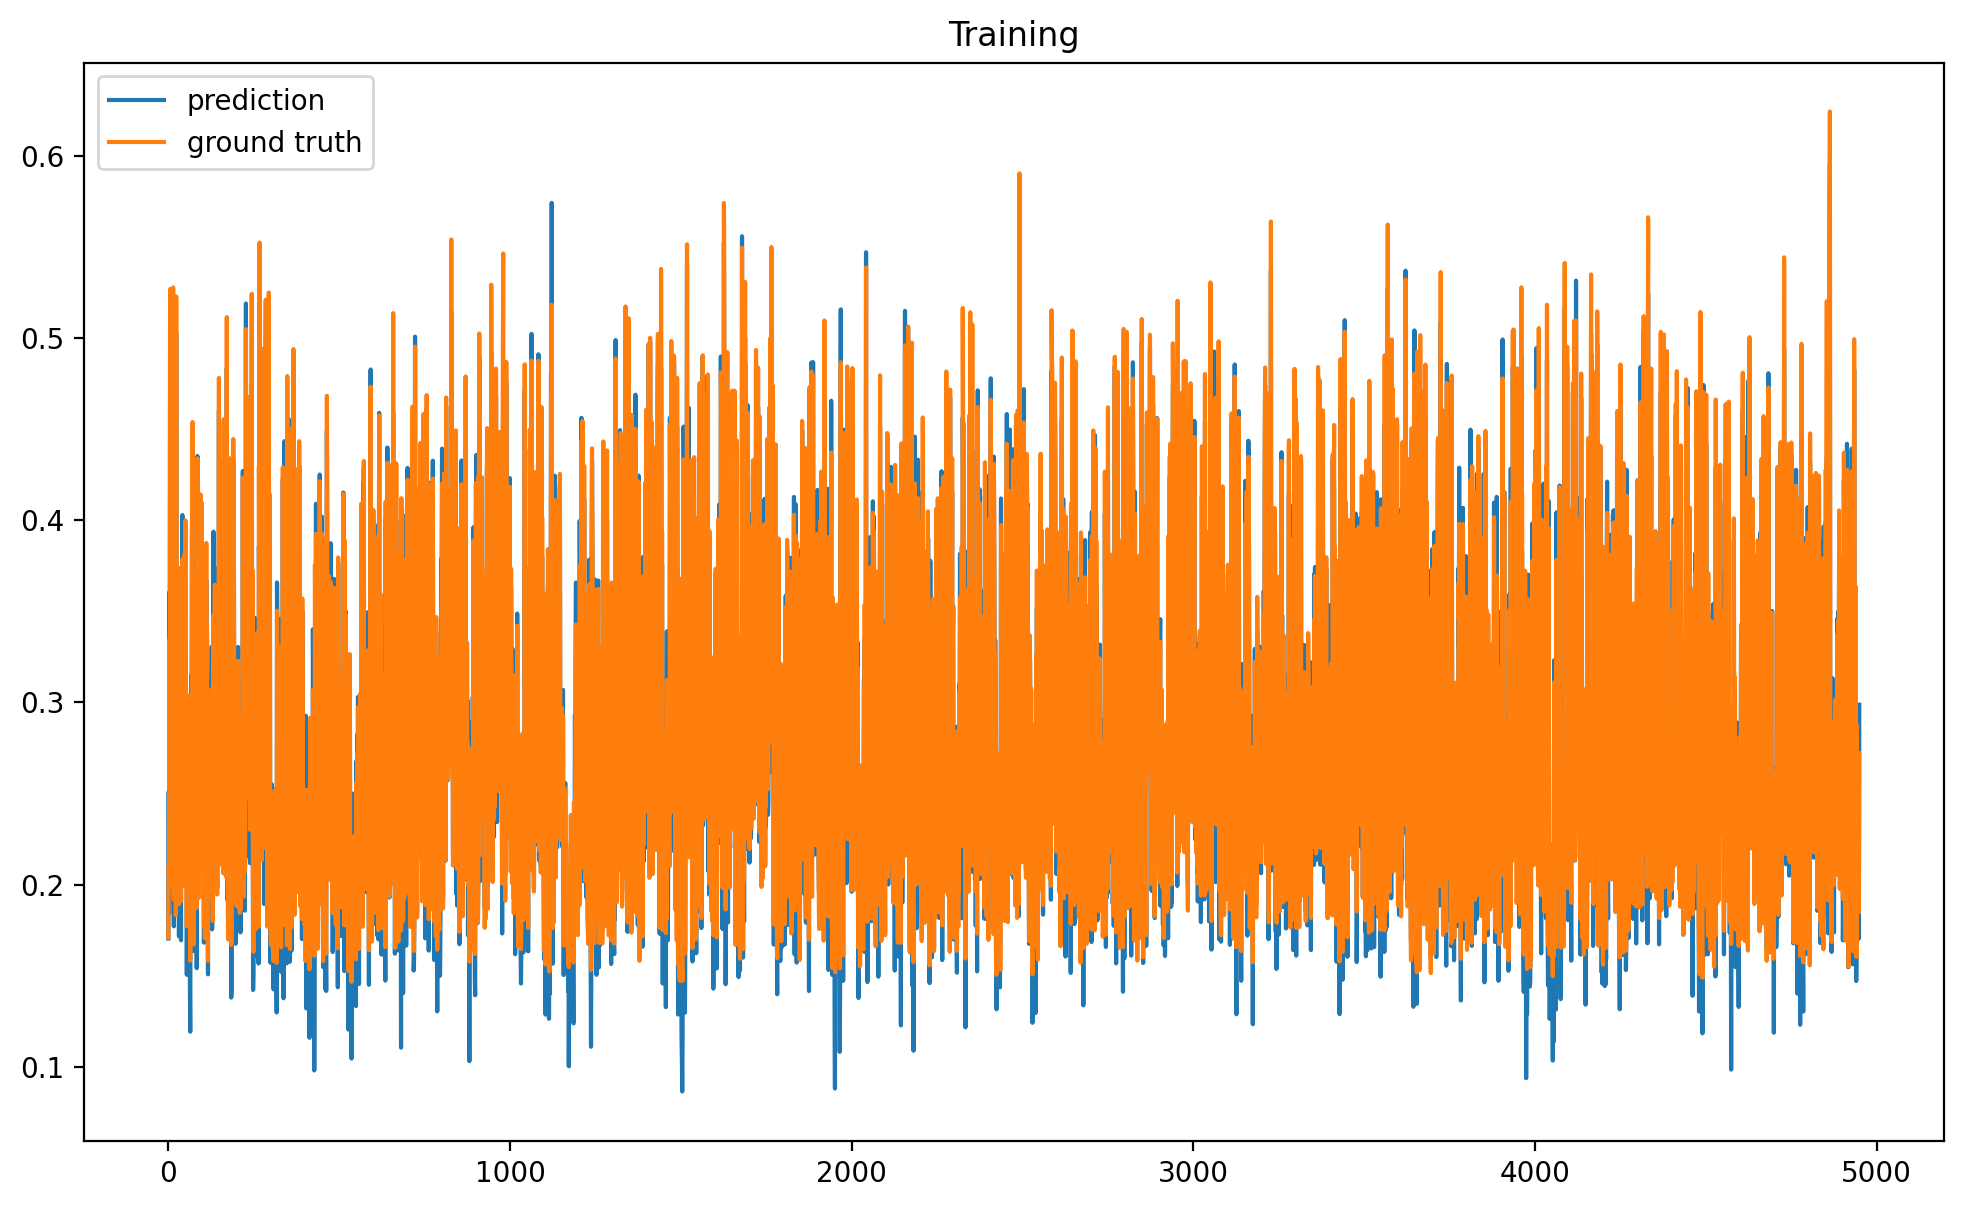

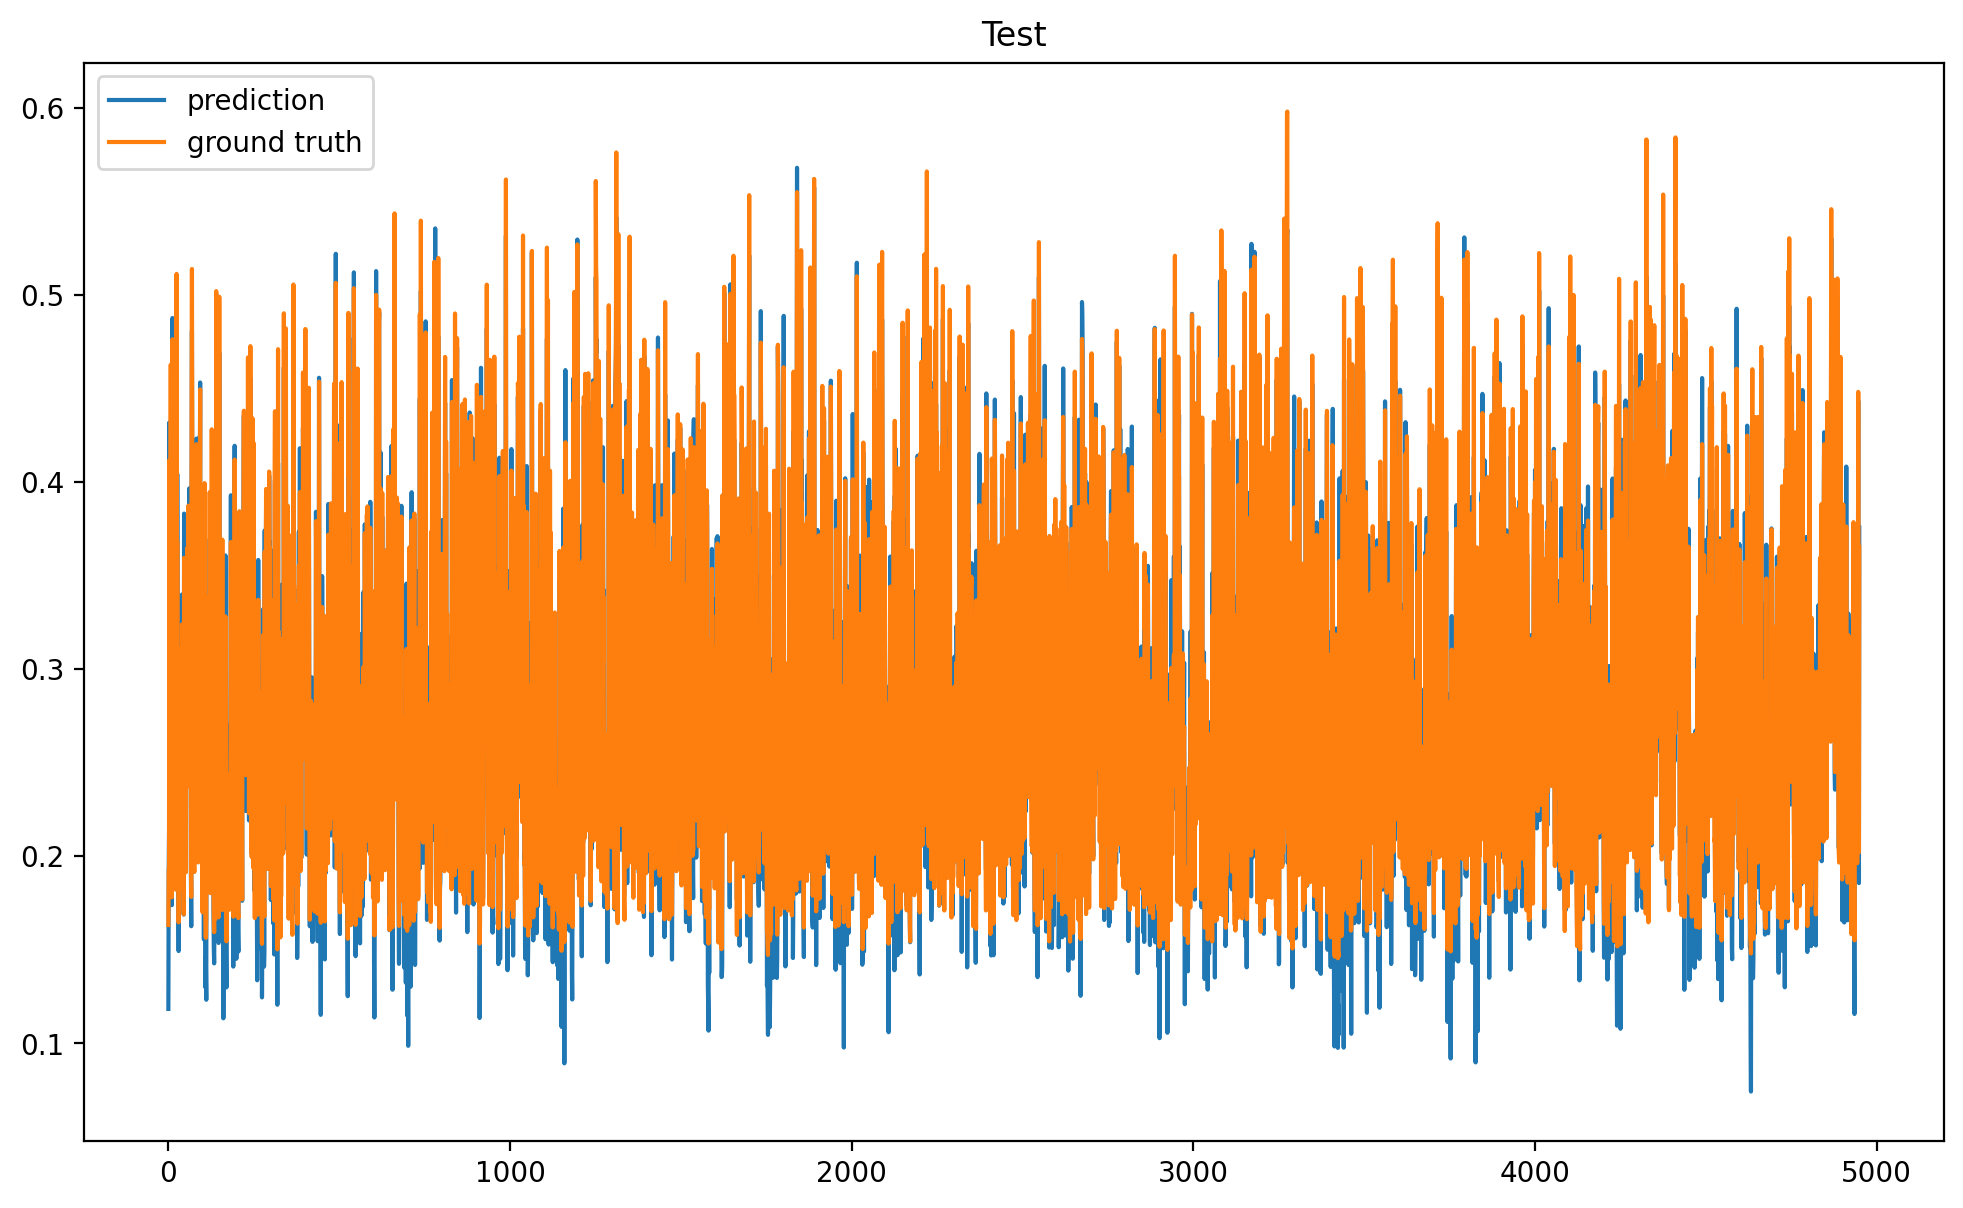

Training loss 0.00045475219045451533
Validation loss 0.0005099494641263967


Test loss 0.0004706395066700293


In [18]:
train_x, train_y, val_x, val_y, test_x, test_y = split(df.values, 4000, 1000)

train_x = np.concatenate((train_x, val_x))
train_y = np.concatenate((train_y, val_y))
model, metrics = train(best_config, train_x, train_y, test_x, test_y, iterations=1, plot=False, washout=0.01)
# print(metrics)

prediction_plot(model, train_x, train_y, washout=0.01, title='Training', save_file='training.png')
prediction_plot(model, test_x, test_y, washout=0.01, title='Test', save_file='test.png')

# model, metrics = train(best_config, train_x, train_y, test_x, test_y, eval_metric='test_loss', iterations=1, plot=True, washout=0.01)
# print(metrics)

print(f'Training loss {evaluate(model, train_x, train_y)}')
print(f'Validation loss {evaluate(model, val_x, val_y)}')
print(f'Test loss {evaluate(model, test_x, test_y)}')

In [16]:
# testing load and dump methods and re-evaluating the model
model.dump('dump')

esn = EchoStateNetwork(**best_config, input_dim=1, stateful=True)
esn.load('dump.npz')

evaluate(esn, test_x, test_y)



0.0004137063652148858